In [1]:
%config IPCompleter.greedy=True


### Loading packages and libraries 

In [1]:
import itertools
import numpy as np
from Bio import Align
from Bio import SeqIO
from Bio import pairwise2
from Bio.SubsMat.MatrixInfo import blosum62
import csv
import pandas as pd
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
import random
from random import randint
from sklearn.model_selection  import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import features_extraction_utility.kmer as kmer
from sklearn.svm import SVC
from xgboost import XGBClassifier
# import the metrics class
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc, classification_report
from sklearn import metrics
# import required modules for plotig
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
seed =45

## Reading np inter v 2 interactions

In [2]:
df_NPInter2 = pd.read_csv('../data/NPInter_v2.0 homo_sapiens_type_lncrna.csv')
df_NPInter2.shape

(5353, 16)

In [3]:
df_NPInter2.prIdentifier=df_NPInter2.prIdentifier.str.strip()

In [4]:
df_NPInter2.prIdentifier.unique()

array(['Q07955', 'Q01844', 'Q9UL18', 'Q9UKV8', 'Q9H9G7', 'Q9HCK5',
       'Q15717', 'B7ZL34', 'Q9NZI8', 'P26599', 'O00425', 'P35637',
       'P31483', 'Q9HCE1', 'Q86X94', 'Q49AS9', 'Q13148', 'Q9Y6M1',
       'Q96PU8', 'O43251', 'Q8NDV7', 'Q9UPQ9', 'Q9HCJ0', 'Q13285',
       'Q6PJX3'], dtype=object)

# Reading kmer features from csv

In [5]:
kmer_features=[]
kmer_labels =[]
with open('X_Features.csv', 'r') as fk:
    reader = csv.reader(fk)
    kmer_features = list(reader)
    
with open('Y_Labels.csv', 'r') as fl:
    reader = csv.reader(fl)
    kmer_labels = list(reader)    
    
    
print(len(kmer_features))
print(len(kmer_labels))

10706
10706


In [6]:
print(len(kmer_features[0]))
#print(len(kmer_features_DAC[0][0]))

8064


## physical-chemical features 

In [7]:
#lncrna features

lnc_dac1 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_0-300.txt", "fasta"))
lnc_dac2 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_301-600.txt", "fasta"))
lnc_dac3 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_601-900.txt", "fasta"))
lnc_dac4 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_901-1200.txt", "fasta"))

lnc_dac5 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_1201-1500.txt", "fasta"))
lnc_dac6 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_1501-1800.txt", "fasta"))
lnc_dac7 = SeqIO.to_dict(SeqIO.parse("../Data/LncRNA DAC/lncRNA_1801-1923.txt", "fasta"))

lnc_DAC ={**lnc_dac1 , **lnc_dac2 , **lnc_dac3 , **lnc_dac4 , **lnc_dac5 , **lnc_dac6 , **lnc_dac7}

In [8]:
print(len(lnc_DAC))
#print(lnc_DAC.keys())

1923


In [9]:
#protein features.
pro_PseAAC = SeqIO.to_dict(SeqIO.parse("../Data/Protein  PC-PseAAC-General/PC-PseAAC-General.txt", "fasta"))
print(len(pro_PseAAC))
print(str(pro_PseAAC['Q07955'].seq))

25
0.018,0.004,0.036,0.02,0.013,0.063,0.005,0.013,0.014,0.011,0.005,0.013,0.03,0.002,0.077,0.05,0.013,0.03,0.002,0.027,0.062,0.048,0.056,0.054,0.056,0.058,0.056,0.056,0.056,0.054


In [10]:
str(lnc_dac1['n344453'].seq)

'0.001,-0.665,0.03,-0.544,-0.0,0.008,0.0,-0.011,0.01,-0.063,-0.0,0.001,0.0,0.034,0.008,-0.001,0.0,0.003,0.0,-0.185,0.014,-0.032,0.0,0.003,0.001,0.203,0.005,0.06,0.0,0.003,0.0,0.049,0.0,0.046,0.0,0.002,0.0,0.165,-0.001,0.024,0.0,0.003,0.0,0.001,0.003,-0.01,0.0,0.002,0.0,-0.042,-0.001,-0.03,0.0,0.001,0.0,-0.076,-0.004,-0.022,0.0,0.002'

In [11]:
type(pro_PseAAC['Q07955'].seq)

Bio.Seq.Seq

### preparing the features set for NPInterV2 dataset

In [12]:
# creating features from npinter v2

def prepare_NPinter_feature_DAC(pro_PseAAC, lnc_DAC, df_NPInter2):
    # create dict of proteins
    pro_dict=pro_PseAAC
    # create dict of lncRnas
    lnc_dict = lnc_DAC
    # positive set
    posi_set = set()
    pro_set = set()
    X_features =[]
    Y_labels =[]
    df_interact = pd.DataFrame(columns=['ncIdentifier', 'prIdentifier', 'interaction'])
    # geting positive class
    for index, row in tqdm(df_NPInter2.iterrows()):
        ncIdentifier=row['ncIdentifier'].strip()
        prIdentifier =row['prIdentifier'].strip()
        posi_set.add((ncIdentifier, prIdentifier))
        pro_set.add(prIdentifier)
        if (ncIdentifier in lnc_dict) and (prIdentifier in pro_dict):
            PseAAC=str(pro_dict[prIdentifier].seq)
            DAC = str(lnc_dict[ncIdentifier].seq)
            df_interact = df_interact.append({'ncIdentifier': ncIdentifier, 'prIdentifier': prIdentifier, 'interaction': 1}, ignore_index=True)
            pro_fea = PseAAC.split(",")
            lnc_fea = DAC.split(",")
            #X_features.append((sim_lst_pro,sim_lst_lnc))
            X_features.append(pro_fea + lnc_fea)
            Y_labels.append(1)

        else:
            print(prIdentifier)
    #getting negative data or class
    pro_list = list(pro_set)   
    total_pro_len = len(pro_list)  
    for index, row in tqdm(df_NPInter2.iterrows()):
        ncIdentifier=row['ncIdentifier'].strip()
        prIdentifier =row['prIdentifier'].strip()
        #posi_set.add((ncIdentifier, prIdentifier))
        for val in range(50):
                    random_choice = randint(0,total_pro_len-1)
                    select_pro = pro_list[random_choice]
                    selec_nega= (ncIdentifier, select_pro)
                    if selec_nega not in posi_set:
                        posi_set.add(selec_nega)
                        #print selec_nega
                        break
        if (ncIdentifier in lnc_dict) and (select_pro in pro_dict):
            PseAAC=str(pro_dict[prIdentifier].seq)
            DAC = str(lnc_dict[ncIdentifier].seq)
            df_interact = df_interact.append({'ncIdentifier': ncIdentifier, 'prIdentifier': prIdentifier, 'interaction': 1}, ignore_index=True)
            pro_fea = PseAAC.split(",")
            lnc_fea = DAC.split(",")
            #X_features.append((sim_lst_pro,sim_lst_lnc))
            X_features.append(pro_fea + lnc_fea)
            Y_labels.append(0)
    return df_interact,np.array(X_features) , Y_labels

        
    


In [13]:
df_interact_DAC, X_Features_DAC, Y_Labels_DAC=prepare_NPinter_feature_DAC(pro_PseAAC, lnc_DAC, df_NPInter2)
df_interact_DAC.shape

5353it [00:14, 376.54it/s]
5353it [00:15, 350.12it/s]


(10706, 3)

In [14]:
#X= X_Features_DAC + kmer_features
X_Features_DAC=X_Features_DAC.astype(float)
kmer_features= np.asarray(kmer_features)
kmer_features = kmer_features.astype(float)
X_Features_DAC=X_Features_DAC.tolist()
kmer_features=kmer_features.tolist()

# Using map() and lambda 
def listOfTuples(l1, l2): 
    return list(map(lambda x, y:(x+y), l1, l2)) 
# for i in range(0,10706):
#     #print(X_Features_DAC[i])
#     #print(kmer_features[i])
#     X_fea.append(X_Features_DAC[i]+kmer_features[i])
    
# #X = [y for x in [X_Features_DAC, kmer_features] for y in x] 
X_fea=listOfTuples(X_Features_DAC,kmer_features)
len(X_fea)

10706

In [15]:
type(kmer_features[0])

list

In [61]:
import csv



with open("X_Features_DAC.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(map(lambda x: [x], X_Features_DAC))    
    
print("done...")    

done...


In [32]:
#df_lnc_sim.count()

In [30]:
# save pairs to disk
df_interact_DAC.to_csv('../data/NpInterV2_Pairs_full_DAC.csv')

### Model



#### train test split

In [16]:
#spliting train test
#X_Features_DAC=X_Features_DAC.astype(float)
X_fea=np.array(X_fea)
X_train,X_test,y_train,y_test=train_test_split(X_fea,Y_Labels_DAC,test_size=0.25,random_state=0)
len(X_train)

8029

## PCA

In [29]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.80)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [31]:
print("Done")

Done


In [32]:
X_train=np.array(X_train)
X_test=np.array(X_test)

### building model

In [33]:
def train_model(model,X_train,y_train):
        
    # fiting kfold model
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
    pred_test_full =0
    cv_score =[]
    i=1
    y_train1=np.array(y_train)
    #y_train1=y_train1.reshape(-1,1)
    #print(y_train.shape)
    #print(X_train.shape)

    for train_index,test_index in kf.split(X_train,y_train1):
        print('{} of KFold {}'.format(i,kf.n_splits))
        #print(train_index)
        #print(test_index)
        xtr,xvl = X_train[train_index],X_train[test_index]
        ytr,yvl = y_train1[train_index],y_train1[test_index]
        #print(xtr[0])
        #print(ytr[0])

        #model
        #medel = LogisticRegression(solver='lbfgs')#LogisticRegression(C=2)
        model.fit(xtr,ytr)
        score = roc_auc_score(yvl,model.predict(xvl))
        print('ROC AUC score:',score)
        cv_score.append(score)    
        pred_test = model.predict_proba(X_test)[:,1]
        pred_test_full +=pred_test
        i+=1
    return model,xtr,xvl, ytr,yvl,cv_score    

### Logistic Regration Model


In [34]:
model = LogisticRegression(solver='lbfgs')#LogisticRegression(C=2)
model,xtr,xvl, ytr,yvl,cv_score =train_model(model,X_train,y_train)

1 of KFold 5
ROC AUC score: 0.47922667100946886
2 of KFold 5
ROC AUC score: 0.4944706822076945
3 of KFold 5
ROC AUC score: 0.492174425548085
4 of KFold 5
ROC AUC score: 0.5020837695523037
5 of KFold 5
ROC AUC score: 0.5003136967453186


In [35]:
print('Confusion matrix on validation set: \n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))


Confusion matrix on validation set: 
 [[304 490]
 [310 501]]
Cv [0.47922667100946886, 0.4944706822076945, 0.492174425548085, 0.5020837695523037, 0.5003136967453186] 
Mean cv Score 0.49365384901257414


In [36]:
print("Results on validation set: ")
print("Accuracy:",metrics.accuracy_score(yvl, model.predict(xvl)))
print("Precision:",metrics.precision_score(yvl, model.predict(xvl)))
print("Recall:",metrics.recall_score(yvl, model.predict(xvl)))
print("F1 Score:",metrics.f1_score(yvl, model.predict(xvl)))

Results on validation set: 
Accuracy: 0.5015576323987538
Precision: 0.5055499495459133
Recall: 0.6177558569667078
F1 Score: 0.556048834628191


In [37]:
print("Results on test set:")
y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Results on test set:


array([[490, 889],
       [525, 773]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

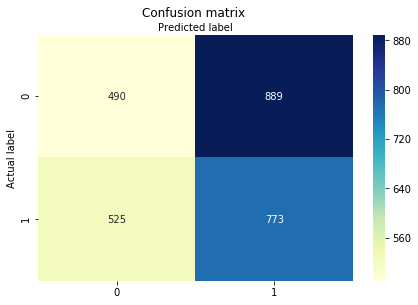

In [38]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [39]:
print("Results on test set:")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Results on test set:
Accuracy: 0.4717967874486365
Precision: 0.4651022864019254
Recall: 0.5955315870570108
F1 Score: 0.5222972972972972


In [40]:
#lr.coef_


In [41]:
print("validation set score:")
print(model.score(xvl,yvl))

print("test set score:")
print(model.score(X_test,y_test))


validation set score:
0.5015576323987538
test set score:
0.4717967874486365


### Reciever Operating Characteristics


Text(0.5, 0, 'False positive rate')

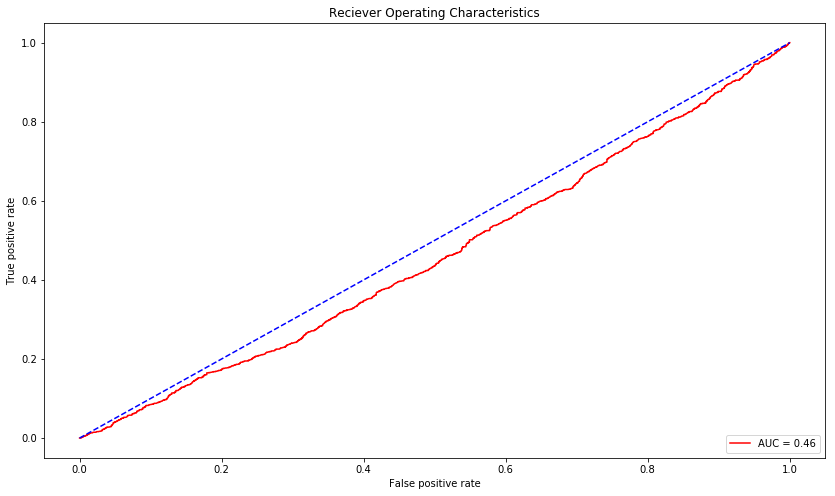

In [42]:
# proba = model.predict_proba(xvl)[:,1]
# frp,trp, threshold = roc_curve(yvl,proba)
proba = model.predict_proba(X_test)[:,1]
frp,trp, threshold = roc_curve(y_test,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### XGBoost Model


In [43]:
model = XGBClassifier(learning_rate=0.05, n_estimators=50, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

model,xtr,xvl, ytr,yvl,cv_score =train_model(model,X_train,y_train)

1 of KFold 5
ROC AUC score: 0.3925458902356746
2 of KFold 5
ROC AUC score: 0.3918463888824264
3 of KFold 5
ROC AUC score: 0.3883419026126608
4 of KFold 5
ROC AUC score: 0.40355644479600467
5 of KFold 5
ROC AUC score: 0.40183388359676614


In [44]:
print('Confusion matrix on validation set: \n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))


Confusion matrix on validation set: 
 [[223 571]
 [387 424]]
Cv [0.3925458902356746, 0.3918463888824264, 0.3883419026126608, 0.40355644479600467, 0.40183388359676614] 
Mean cv Score 0.39562490202470657


In [45]:
print("Results on validation set: ")
print("Accuracy:",metrics.accuracy_score(yvl, model.predict(xvl)))
print("Precision:",metrics.precision_score(yvl, model.predict(xvl)))
print("Recall:",metrics.recall_score(yvl, model.predict(xvl)))
print("F1 Score:",metrics.f1_score(yvl, model.predict(xvl)))

Results on validation set: 
Accuracy: 0.4031152647975078
Precision: 0.42613065326633165
Recall: 0.5228113440197287
F1 Score: 0.46954595791805087


In [46]:
print("Results on test set:")
y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Results on test set:


array([[ 375, 1004],
       [ 624,  674]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

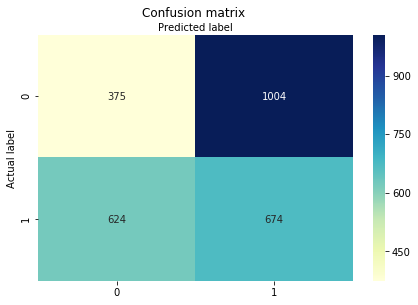

In [47]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
print("Results on test set: ")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

Results on test set: 
Accuracy: 0.39185655584609635
Precision: 0.40166865315852207
Recall: 0.5192604006163328
F1 Score: 0.4529569892473118


In [49]:
#lr.coef_


In [50]:
print("validation set score:")
print(model.score(xvl,yvl))

print("test set score:")
print(model.score(X_test,y_test))


validation set score:
0.4031152647975078
test set score:
0.39185655584609635


### Reciever Operating Characteristics


Text(0.5, 0, 'False positive rate')

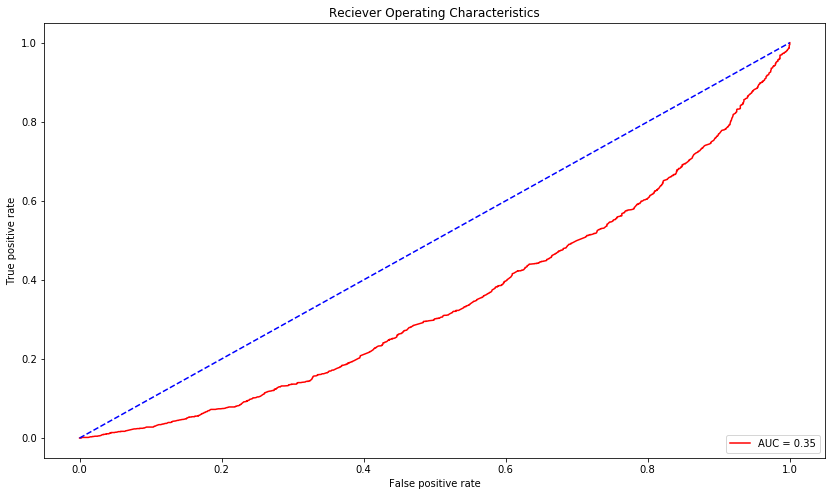

In [51]:
#proba = model.predict_proba(xvl)[:,1]
#frp,trp, threshold = roc_curve(yvl,proba)
proba = model.predict_proba(X_test)[:,1]
frp,trp, threshold = roc_curve(y_test,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

### SVM

In [52]:
model = SVC(kernel='linear',probability=True)

model,xtr,xvl, ytr,yvl,cv_score =train_model(model,X_train,y_train)

1 of KFold 5
ROC AUC score: 0.4811382794748311
2 of KFold 5
ROC AUC score: 0.4944706822076945
3 of KFold 5
ROC AUC score: 0.49089174790033274
4 of KFold 5
ROC AUC score: 0.4993609876772988
5 of KFold 5
ROC AUC score: 0.5041409523336242


In [53]:
print('Confusion matrix on validation set: \n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))


Confusion matrix on validation set: 
 [[267 527]
 [266 545]]
Cv [0.4811382794748311, 0.4944706822076945, 0.49089174790033274, 0.4993609876772988, 0.5041409523336242] 
Mean cv Score 0.4940005299187563


In [54]:
print("Results on validation set: ")
print("Accuracy:",metrics.accuracy_score(yvl, model.predict(xvl)))
print("Precision:",metrics.precision_score(yvl, model.predict(xvl)))
print("Recall:",metrics.recall_score(yvl, model.predict(xvl)))
print("F1 Score:",metrics.f1_score(yvl, model.predict(xvl)))

Results on validation set: 
Accuracy: 0.5059190031152648
Precision: 0.5083955223880597
Recall: 0.6720098643649816
F1 Score: 0.5788635156664896


In [55]:
print("Results on test set:")
y_pred=model.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Results on test set:


array([[428, 951],
       [462, 836]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

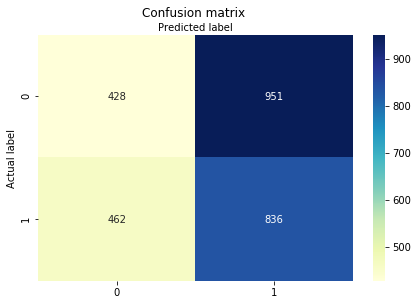

In [56]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix ', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [57]:
print('results on test set')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:",metrics.f1_score(y_test, y_pred))

results on test set
Accuracy: 0.47217033993276053
Precision: 0.46782316731952994
Recall: 0.6440677966101694
F1 Score: 0.5419773095623986


In [25]:
#lr.coef_


In [58]:
print("validation set score:")
print(model.score(xvl,yvl))

print("test set score:")
print(model.score(X_test,y_test))


validation set score:
0.5059190031152648
test set score:
0.47217033993276053


### Reciever Operating Characteristics


Text(0.5, 0, 'False positive rate')

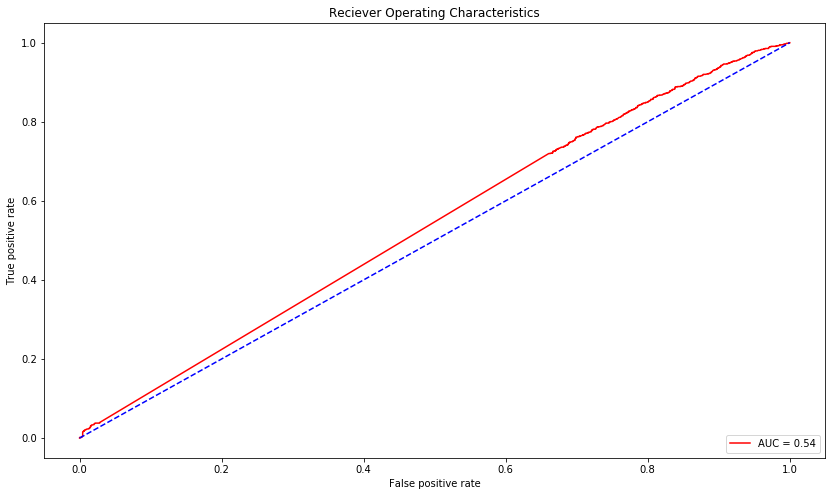

In [28]:
#proba = model.predict_proba(xvl)[:,1]
#frp,trp, threshold = roc_curve(yvl,proba)
proba = model.predict_proba(X_test)[:,1]
frp,trp, threshold = roc_curve(y_test,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')